# Implementation of Multilayer Perceptrons
:label:`sec_mlp-implementation`

Multilayer perceptrons (MLPs) are not much more complex to implement than simple linear models. The key conceptual
difference is that we now concatenate multiple layers.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import jax
import jax.numpy as jnp
import optax
from flax import nnx

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [3]:
x_train = x_train / 255.
y_train = y_train.astype(np.int32)

In [4]:
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))

In [5]:
n_epoch = 10
batch_size = 256
train_data = train_data.repeat(n_epoch).shuffle(buffer_size=batch_size)
train_data = train_data.batch(batch_size, drop_remainder=True).prefetch(1)

In [6]:
train_data.cardinality().numpy() # (60000 * n_epoch) / batch_size

2343

In [7]:
x_test = x_test / 255.
y_test = y_test.astype(np.int32)
test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test))

In [8]:
test_data = test_data.shuffle(batch_size) 
test_data = test_data.batch(batch_size, drop_remainder=True).prefetch(1)

## Implementation from Scratch

Let's begin again by implementing such a network from scratch.

### Initializing Model Parameters

Recall that Fashion-MNIST contains 10 classes,
and that each image consists of a $28 \times 28 = 784$
grid of grayscale pixel values.
As before we will disregard the spatial structure
among the pixels for now,
so we can think of this as a classification dataset
with 784 input features and 10 classes.
To begin, we will [**implement an MLP
with one hidden layer and 256 hidden units.**]
Both the number of layers and their width are adjustable
(they are considered hyperparameters).
Typically, we choose the layer widths to be divisible by larger powers of 2.
This is computationally efficient due to the way
memory is allocated and addressed in hardware.

Again, we will represent our parameters with several tensors.
Note that *for every layer*, we must keep track of
one weight matrix and one bias vector.
As always, we allocate memory
for the gradients of the loss with respect to these parameters.


In the code below we use `flax.linen.Module.param`
to define the model parameter.


In [18]:
class MLPScratch(nnx.Module):
	def __init__(self, num_inputs: int, num_hiddens: int, num_outputs: int, *, rngs: nnx.Rngs):
		key = rngs.params()
		self.w1 = nnx.Param(nnx.initializers.glorot_normal()(key, (num_inputs, num_hiddens)))
		self.b1 = nnx.Param(nnx.initializers.zeros(key, (num_hiddens,)))
		self.w2 = nnx.Param(nnx.initializers.glorot_normal()(key, (num_hiddens, num_outputs)))
		self.b2 = nnx.Param(nnx.initializers.zeros(key, (num_outputs,)))
		self.din = num_inputs
	
	def __call__(self, x: jax.Array):
		x = x.reshape((-1, self.din))
		x = nnx.relu(x @ self.w1 + self.b1)
		return x @ self.w2 + self.b2

### Training

In [19]:
model = MLPScratch(num_inputs=784, num_hiddens=256, num_outputs=10, rngs=nnx.Rngs(params=0))

In [20]:
def loss_fn(model, batch):
  x, y = batch
  logits = model(x)
  loss = optax.softmax_cross_entropy_with_integer_labels(logits=logits, labels=y).mean()
  return loss, logits

In [21]:
optimizer = nnx.Optimizer(model, optax.adam(learning_rate=0.1))

In [23]:
metrics = nnx.MultiMetric(
  accuracy=nnx.metrics.Accuracy(),
  loss=nnx.metrics.Average('loss'),
)

In [24]:
@nnx.jit
def train_step(model, optimizer: nnx.Optimizer, metrics: nnx.MultiMetric, batch):
  """Train for a single step."""
  grad_fn = nnx.value_and_grad(loss_fn, has_aux=True)
  (loss, logits), grads = grad_fn(model, batch)
  metrics.update(loss=loss, logits=logits, labels=batch[1])
  optimizer.update(grads)

In [25]:
@nnx.jit
def eval_step(model, metrics: nnx.MultiMetric, batch):
  loss, logits = loss_fn(model, batch)
  metrics.update(loss=loss, logits=logits, labels=batch[1])

In [26]:
eval_every = 250

metrics_history = {
  'train_loss': [],
  'train_accuracy': [],
  'test_loss': [],
  'test_accuracy': [],
}

for step, batch in enumerate(train_data.as_numpy_iterator()):
  train_step(model, optimizer, metrics, batch)
  
  if step > 0 and (step % eval_every == 0): 
    for metric, value in metrics.compute().items():
      metrics_history[f'train_{metric}'].append(value)
    metrics.reset()

    for test_batch in test_data.as_numpy_iterator():
      eval_step(model, metrics, test_batch)

    for metric, value in metrics.compute().items():
      metrics_history[f'test_{metric}'].append(value)
    metrics.reset()

2024-10-21 12:21:50.599782: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-10-21 12:21:51.167917: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-10-21 12:21:51.731041: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-10-21 12:21:52.294656: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-10-21 12:21:52.854993: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-10-21 12:21:53.421871: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-10-21 12:21:53.985900: W tensorflow/core/framework/local_rendezvous.cc:404] L

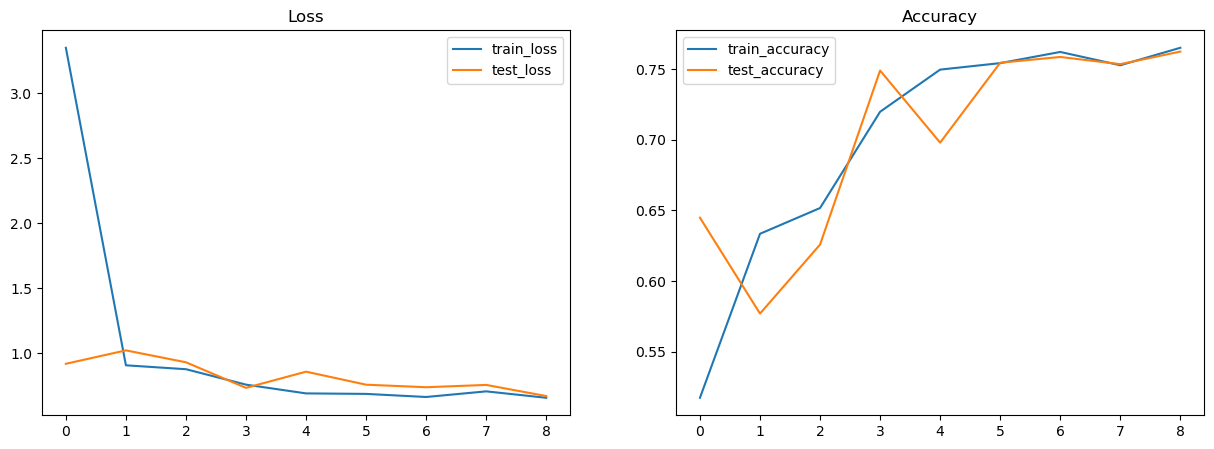

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title('Loss')
ax2.set_title('Accuracy')
for dataset in ('train', 'test'):
  ax1.plot(metrics_history[f'{dataset}_loss'], label=f'{dataset}_loss')
  ax2.plot(metrics_history[f'{dataset}_accuracy'], label=f'{dataset}_accuracy')
ax1.legend()
ax2.legend()
plt.show()

## Concise Implementation

As you might expect, by relying on the high-level APIs, we can implement MLPs even more concisely.

### Model

Compared with our concise implementation
of softmax regression implementation
(:numref:`sec_softmax_concise`),
the only difference is that we add
*two* fully connected layers where we previously added only *one*.
The first is [**the hidden layer**],
the second is the output layer.


In [24]:
class MLP(nn.Module):
    num_outputs: int
    num_hiddens: int
    lr: float

    @nn.compact
    def __call__(self, X):
        X = X.reshape((X.shape[0], -1))  # Flatten
        X = nn.Dense(self.num_hiddens)(X)
        X = nn.relu(X)
        X = nn.Dense(self.num_outputs)(X)
        return X

In [ ]:
model = MLP(num_outputs=10, num_hiddens=256, lr=0.1)

In [34]:
variables = model.init(key(), jnp.ones((64, 28, 28)))

In [35]:
state = TrainState.create(apply_fn=model.apply, 
                          params=variables['params'], 
                          tx=optax.adam(learning_rate=0.01),
                          metrics=Metrics.empty())

In [36]:
# train + compute_metrics
@jax.jit
def train_step(state, batch):
  """Train for a single step."""
  X, y = batch

  def loss_fn(params):
    logits = state.apply_fn({'params': params}, X)
    loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=y).mean()
    return loss, logits
  
  grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
  (loss, logits), grads = grad_fn(state.params)
  state = state.apply_gradients(grads=grads)

  metric_updates = state.metrics.single_from_model_output(
    logits=logits, labels=y, loss=loss)
  metrics = state.metrics.merge(metric_updates)
  state = state.replace(metrics=metrics)
  return state

In [28]:
# since train_ds is replicated n_epoch times, we divide by n_epoch
num_steps_per_epoch = train_data.cardinality().numpy() // n_epoch
num_steps_per_epoch

234

In [42]:
state.metrics

Metrics(_reduction_counter=_ReductionCounter(value=Array(4, dtype=int32)), accuracy=Accuracy(total=Array(675., dtype=float32), count=Array(768, dtype=int32)), loss=Metric.from_output.<locals>.FromOutput(total=Array(1.0320823, dtype=float32), count=Array(3, dtype=int32)))

In [37]:
metrics_history = {'train_loss': [],
                   'train_accuracy': [],
                   'test_loss': [],
                   'test_accuracy': []}

In [38]:
for step, batch in enumerate(train_data.as_numpy_iterator()):

  # Run optimization steps over training batches and compute batch metrics
  state = train_step(state, batch)

  if (step+1) % num_steps_per_epoch == 0: # one training epoch has passed
    for metric, value in state.metrics.compute().items(): # compute metrics
      metrics_history[f'train_{metric}'].append(value) # record metrics
    state = state.replace(metrics=state.metrics.empty()) # reset train_metrics for next training epoch

    # Compute metrics on the test set after each training epoch
    test_state = state
    for test_batch in test_data.as_numpy_iterator():
      test_state = compute_metrics(state=test_state, batch=test_batch)

    for metric,value in test_state.metrics.compute().items():
      metrics_history[f'test_{metric}'].append(value)

    # print(f"train epoch: {(step+1) // num_steps_per_epoch}, "
    #       f"loss: {metrics_history['train_loss'][-1]}, "
    #       f"accuracy: {metrics_history['train_accuracy'][-1] * 100}")
    # print(f"test epoch: {(step+1) // num_steps_per_epoch}, "
    #       f"loss: {metrics_history['test_loss'][-1]}, "
    #       f"accuracy: {metrics_history['test_accuracy'][-1] * 100}")

2024-08-06 22:42:56.364399: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-06 22:42:56.891936: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-06 22:42:57.388274: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-06 22:42:57.923254: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-06 22:42:58.413276: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-06 22:42:58.893185: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-06 22:42:59.336446: W tensorflow/core/framework/local_rendezvous.cc:404] L

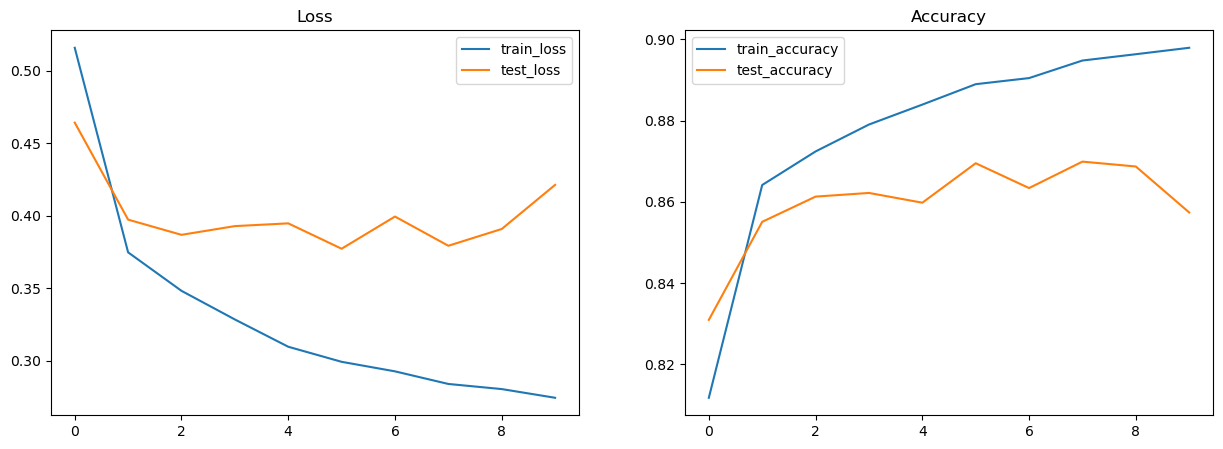

In [39]:

# Plot loss and accuracy in subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title('Loss')
ax2.set_title('Accuracy')
for dataset in ('train', 'test'):
  ax1.plot(metrics_history[f'{dataset}_loss'], label=f'{dataset}_loss')
  ax2.plot(metrics_history[f'{dataset}_accuracy'], label=f'{dataset}_accuracy')
ax1.legend()
ax2.legend();

## Summary

Now that we have more practice in designing deep networks, the step from a single to multiple layers of deep networks does not pose such a significant challenge any longer. In particular, we can reuse the training algorithm and data loader. Note, though, that implementing MLPs from scratch is nonetheless messy: naming and keeping track of the model parameters makes it difficult to extend models. For instance, imagine wanting to insert another layer between layers 42 and 43. This might now be layer 42b, unless we are willing to perform sequential renaming. Moreover, if we implement the network from scratch, it is much more difficult for the framework to perform meaningful performance optimizations.

Nonetheless, you have now reached the state of the art of the late 1980s when fully connected deep networks were the method of choice for neural network modeling. Our next conceptual step will be to consider images. Before we do so, we need to review a number of statistical basics and details on how to compute models efficiently.


## Exercises

1. Change the number of hidden units `num_hiddens` and plot how its number affects the accuracy of the model. What is the best value of this hyperparameter?
1. Try adding a hidden layer to see how it affects the results.
1. Why is it a bad idea to insert a hidden layer with a single neuron? What could go wrong?
1. How does changing the learning rate alter your results? With all other parameters fixed, which learning rate gives you the best results? How does this relate to the number of epochs?
1. Let's optimize over all hyperparameters jointly, i.e., learning rate, number of epochs, number of hidden layers, and number of hidden units per layer.
    1. What is the best result you can get by optimizing over all of them?
    1. Why it is much more challenging to deal with multiple hyperparameters?
    1. Describe an efficient strategy for optimizing over multiple parameters jointly.
1. Compare the speed of the framework and the from-scratch implementation for a challenging problem. How does it change with the complexity of the network?
1. Measure the speed of tensor--matrix multiplications for well-aligned and misaligned matrices. For instance, test for matrices with dimension 1024, 1025, 1026, 1028, and 1032.
    1. How does this change between GPUs and CPUs?
    1. Determine the memory bus width of your CPU and GPU.
1. Try out different activation functions. Which one works best?
1. Is there a difference between weight initializations of the network? Does it matter?


[Discussions](https://discuss.d2l.ai/t/17985)
